#### Import Modules

In [8]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas import DataFrame
from datetime import datetime, timedelta
from tqdm import tqdm
from multiprocessing import Pool, cpu_count

# Dask
import dask
import dask.dataframe as dd
import dask.array as da
from dask.distributed import Client, progress

# Set the warning filter to 'ignore' to suppress all warnings
import warnings
warnings.filterwarnings('ignore')

#### Import Data

In [2]:
file1 = pd.read_csv('../data/raw/File1.txt', header=None, sep=' ', names=['MeterID', 'codeDateTime', 'kWh'])


In [3]:
file_1 = file1.copy()

In [4]:
file_1.head()

,MeterID,codeDateTime,kWh
0,1392,19503,0.140
1,1392,19504,0.138
2,1392,19505,0.140
3,1392,19506,0.145
4,1392,19507,0.145


In [5]:
file_1['MeterID'].nunique()

1000

In [6]:
def code_to_datetime(code):
    if len(str(code)) != 5:
        raise ValueError("Input code must be a 5-digit integer.")

    day_code = int(str(code)[:3])
    time_code = int(str(code)[3:5])

    # Calculate the date
    base_date = datetime(2009, 1, 1)
    delta = timedelta(days=day_code)
    target_date = base_date + delta

    # Calculate the time
    hours = (time_code) // 2
    minutes = 30 * (time_code % 2)

    target_time = timedelta(hours=hours, minutes=minutes)

    # Combine the date and time to create the datetime object
    result_datetime = target_date + target_time

    return result_datetime

In [13]:
# Use tqdm to track progress
tqdm.pandas(desc="Converting")

# Apply the conversion function to the 'code' column
file_1['DateTime'] = file_1['codeDateTime'].progress_apply(code_to_datetime)
file_1.drop(columns=['codeDateTime'], inplace=True)

Converting: 100%|██████████| 24465838/24465838 [00:43<00:00, 560934.01it/s]


In [14]:
file_1.head(20)

,MeterID,kWh,DateTime
0,1392,0.140,2009-07-15 01:30:00
1,1392,0.138,2009-07-15 02:00:00
2,1392,0.140,2009-07-15 02:30:00
3,1392,0.145,2009-07-15 03:00:00
4,1392,0.145,2009-07-15 03:30:00
5,1392,0.157,2009-07-15 00:30:00
6,1392,0.144,2009-07-15 01:00:00
7,1392,0.128,2009-07-17 12:00:00
8,1392,0.142,2009-07-17 12:30:00
9,1392,0.145,2009-07-17 13:00:00


In [18]:
file_1.dtypes

MeterID              int64
kWh                float64
DateTime    datetime64[ns]
dtype: object

In [2]:
ddd = pd.read_csv('../data/interim/transformed_File1.txt', parse_dates=['DateTime'])

In [3]:
ddd.dtypes

MeterID              int64
kWh                float64
DateTime    datetime64[ns]
dtype: object

In [4]:
ddd.isna().sum()

MeterID     0
kWh         0
DateTime    0
dtype: int64

In [5]:
cpu_count()

16

In [6]:
def group_by_meter_id_dask(df):
    # Create a Dask DataFrame from the Pandas DataFrame
    dask_df = dd.from_pandas(df, npartitions=cpu_count()-4)  # You can adjust the number of partitions as needed

    # Get unique datetimes
    unique_datetimes = dask_df['DateTime'].unique().compute()
    meter_ids = dask_df['MeterID'].unique().compute()

    # Scatter the Dask DataFrame ahead of time
    dask_df = dask_df.repartition(npartitions=10)  # You can adjust the number of partitions as needed

    # Initialize a Dask client
    client = Client()

    # Create a list of futures for the results
    results = []

    # Iterate through MeterIDs and compute the results as futures
    for meter_id in tqdm(meter_ids, desc="Processing MeterIDs"):
        meter_data = dask_df[dask_df['MeterID'] == meter_id]

        # Perform the required operations and compute the result as a future
        result = meter_data.groupby('DateTime')['kWh'].first().compute().reindex(unique_datetimes, fill_value=np.nan)

        # Append the result to the list of futures
        results.append(result)

    # Close the Dask client
    client.close()

    # Combine the futures into a Pandas DataFrame
    new_df = pd.concat(results, axis=1)
    new_df.columns = meter_ids
    new_df.index = unique_datetimes
    new_df = new_df.sort_index()

    return new_df

In [9]:
experimental_grouped_data = group_by_meter_id_dask(ddd)

Processing MeterIDs: 100%|██████████| 1000/1000 [19:00<00:00,  1.14s/it]


ModuleNotFoundError: No module named 'ipywidgets'

In [42]:
experimental_grouped_data.iloc[:,0].head(36)

DateTime
2009-07-15 00:30:00    0.157
2009-07-15 01:00:00    0.144
2009-07-15 01:30:00    0.140
2009-07-15 02:00:00    0.138
2009-07-15 02:30:00    0.140
2009-07-15 03:00:00    0.145
2009-07-15 03:30:00    0.145
2009-07-15 04:00:00    0.144
2009-07-15 04:30:00    0.141
2009-07-15 05:00:00    0.142
2009-07-15 05:30:00    0.144
2009-07-15 06:00:00    0.148
2009-07-15 06:30:00    0.146
2009-07-15 07:00:00    0.135
2009-07-15 07:30:00    0.136
2009-07-15 08:00:00    1.957
2009-07-15 08:30:00    0.136
2009-07-15 09:00:00    0.134
2009-07-15 09:30:00    0.130
2009-07-15 10:00:00    0.135
2009-07-15 10:30:00    0.147
2009-07-15 11:00:00    0.144
2009-07-15 11:30:00    0.131
2009-07-15 12:00:00    0.165
2009-07-15 12:30:00    0.207
2009-07-15 13:00:00    0.140
2009-07-15 13:30:00    0.139
2009-07-15 14:00:00    0.139
2009-07-15 14:30:00    0.140
2009-07-15 15:00:00    0.135
2009-07-15 15:30:00    0.149
2009-07-15 16:00:00    0.150
2009-07-15 16:30:00    0.150
2009-07-15 17:00:00    0.175
2009-

In [ ]:
def group_by_meter_id(df):
    # Initialize an empty DataFrame with 'DateTime' as the index
    unique_datetimes = df['DateTime'].unique()
    new_df = pd.DataFrame(index=unique_datetimes)

    # Iterate through MeterIDs and populate the new DataFrame with progress tracking
    meter_ids = df['MeterID'].unique()
    for meter_id in tqdm(meter_ids, desc="Processing MeterIDs", unit=" MeterID"):
        meter_data = df[df['MeterID'] == meter_id]
        new_df[meter_id] = new_df.index.map(
            lambda dt: meter_data[meter_data['DateTime'] == dt]['kWh'].values[0] if len(meter_data[meter_data['DateTime'] == dt]['kWh']) > 0 else np.nan
        )

    # Reset the index of the new DataFrame
    new_df.reset_index(inplace=True)
    new_df.set_index('index', inplace=True)
    new_df.sort_index(inplace=True)

    return new_df

In [23]:
def group_by_meter_id(df):
    # Initialize an empty DataFrame with 'DateTime' as the index
    unique_datetimes = df['DateTime'].unique()
    new_df = pd.DataFrame(index=unique_datetimes)

    # Iterate through MeterIDs and populate the new DataFrame with progress tracking
    meter_ids = df['MeterID'].unique()
    for meter_id in tqdm(meter_ids, desc="Processing MeterIDs", unit=" MeterID"):
        meter_data = df[df['MeterID'] == meter_id]
        new_df[meter_id] = new_df.index.map(
            lambda dt: meter_data[meter_data['DateTime'] == dt]['kWh'].values[0] if len(meter_data[meter_data['DateTime'] == dt]['kWh']) > 0 else np.nan
        )

    # Reset the index of the new DataFrame
    new_df.reset_index(inplace=True)
    new_df.set_index('index', inplace=True)
    new_df.sort_index(inplace=True)

    return new_df

In [24]:
grouped_data = group_by_meter_id(ddd)

Processing MeterIDs:   0%|          | 5/1000 [00:36<2:02:42,  7.40s/ MeterID]


KeyboardInterrupt: 

In [37]:
grouped_data.head(36).sort_index()

NameError: name 'grouped_data' is not defined

In [32]:
grouped_data.iloc[:,:3].head()

,1392,1951,1491
index,,,
2009-07-15 01:30:00,0.140,0.014,0.018
2009-07-15 02:00:00,0.138,0.014,0.011
2009-07-15 02:30:00,0.140,0.041,0.111
2009-07-15 03:00:00,0.145,0.115,0.018
2009-07-15 03:30:00,0.145,0.069,0.013


In [49]:
grouped_data.to_csv('../data/interim/grouped_data.csv', index=True, header=True)

In [10]:
def loadRawData(self, filename: str | list[str]) -> DataFrame:
    if type(filename) == str:
        dataframe = pd.read_csv(self.raw_path+"/"+filename, 
                                header=None, sep=' ', 
                                names=['MeterID', 'codeDateTime', 'kWh'])
    else:
        dataframe = pd.DataFrame(columns=['MeterID', 'codeDateTime', 'kWh'])
        for file in filename:
            if len(dataframe)==0:
                dataframe = pd.read_csv(self.raw_path+"/"+file,
                                        header=None, sep=' ',
                                        names=['MeterID', 'codeDateTime', 'kWh'])
            else:    
                dataframe = pd.concat([dataframe, pd.read_csv(self.raw_path+"/"+file,
                                                        header=None, sep=' ',
                                                        names=['MeterID', 'codeDateTime', 'kWh'])], ignore_index=True)

    return dataframe

In [3]:
dataframe = pd.DataFrame(columns=['MeterID', 'codeDateTime', 'kWh'])
len(dataframe)

0

In [4]:
file1 = pd.read_csv('../data/raw/File1.txt', header=None, sep=' ', names=['MeterID', 'codeDateTime', 'kWh'])
file2 = pd.read_csv('../data/raw/File2.txt', header=None, sep=' ', names=['MeterID', 'codeDateTime', 'kWh'])


In [5]:
len(file1)

24465838

In [6]:
len(file2)

24507300

In [7]:
len(file1) + len(file2)

48973138

In [8]:
raw_path = '../data/raw'
combined_file = loadRawData(raw_path=raw_path, filename= ['File1.txt', 'File2.txt'])

In [9]:
assert len(combined_file) == len(file1) + len(file2)

In [14]:
def scan_directory(raw_path, extension: str) -> list:
    """Check `raw_path` directory and return list of files with
    specified extension

    Args:
        extension (str): extension type to be searched for e.g. ".txt"

    Returns:
        list: strings of file names with specified extension
    """
    directory = raw_path    
    files: list = []
    for filename in os.listdir(directory):
        if filename.endswith(extension):
            files.append(filename)
    files.sort()
    return files

In [15]:
scan_directory(raw_path, '.txt')

['File1.txt', 'File2.txt', 'File3.txt', 'File4.txt', 'File5.txt', 'File6.txt']

In [1]:
'File1.txt'[:-4]

'File1'

In [1]:
int(17 * 0.75)

12

In [32]:
def loadData(directory: str, filename: str | list[str], sep=' ', names: list[str]=['MeterID', 'codeDateTime', 'kWh']) -> DataFrame:
    if type(filename) == str:
        # logger.info(f"Loading {filename}")
        try:
            if type(names)==list:
                dataframe = pd.read_csv(directory+"/"+filename, 
                                         sep=sep, 
                                        names=names)
            else:
                dataframe = pd.read_csv(directory+"/"+filename, sep=sep)
            # logger.info(f"Loaded {len(dataframe)} rows from {filename}")
        except Exception as e:
            # logger.error(f"Failed to load {filename}: {e}")
            raise e

        
    else:
        # logger.info(f"Loading files {filename}")
        try:
            dataframe = pd.DataFrame(columns=names)
            total_rows = 0
            if type(names)==list:
                for file in filename:
                    if len(dataframe)==0:
                        dataframe = pd.read_csv(directory+"/"+file,
                                                 sep=sep,
                                                names=names)
                        total_rows += len(dataframe)
                        # logger.info(f"Loaded {len(dataframe)} rows from {file}")
                    else:    
                        dataframe = pd.concat([dataframe, pd.read_csv(directory+"/"+file,
                                                                 sep=sep,
                                                                names=names)],
                                                                ignore_index=True)
                        total_rows += len(dataframe)
                        # logger.info(f"Loaded {len(dataframe)} rows from {file}")
            else:
                for file in filename:
                    if len(dataframe)==0:
                        dataframe = pd.read_csv(directory+"/"+file, sep=sep)
                        total_rows += len(dataframe)
                        # logger.info(f"Loaded {len(dataframe)} rows from {file}")
                    else:    
                        dataframe = pd.concat([dataframe, pd.read_csv(directory+"/"+file, sep=sep)],
                                                ignore_index=True)
                        total_rows += len(dataframe)
            # logger.info(f"Loaded {total_rows} rows from files{filename}")
        except Exception as e:
            # logger.error(f"Failed to load files {filename}: {e}")
            raise e

    return dataframe

In [33]:
qqq = loadData('../data/raw/', 'File1.txt')

In [34]:
qqq.head()

,1392,19503,0.14
0,1392,19504,0.138
1,1392,19505,0.140
2,1392,19506,0.145
3,1392,19507,0.145
4,1392,19501,0.157


In [45]:
ggg = pd.read_csv('../data/interim/grouped_data_File1.csv', parse_dates=['index'], index_col='index')

In [46]:
ggg.iloc[:,0].head(36)

index
2009-07-15 00:30:00    0.157
2009-07-15 01:00:00    0.144
2009-07-15 01:30:00    0.140
2009-07-15 02:00:00    0.138
2009-07-15 02:30:00    0.140
2009-07-15 03:00:00    0.145
2009-07-15 03:30:00    0.145
2009-07-15 04:00:00    0.144
2009-07-15 04:30:00    0.141
2009-07-15 05:00:00    0.142
2009-07-15 05:30:00    0.144
2009-07-15 06:00:00    0.148
2009-07-15 06:30:00    0.146
2009-07-15 07:00:00    0.135
2009-07-15 07:30:00    0.136
2009-07-15 08:00:00    1.957
2009-07-15 08:30:00    0.136
2009-07-15 09:00:00    0.134
2009-07-15 09:30:00    0.130
2009-07-15 10:00:00    0.135
2009-07-15 10:30:00    0.147
2009-07-15 11:00:00    0.144
2009-07-15 11:30:00    0.131
2009-07-15 12:00:00    0.165
2009-07-15 12:30:00    0.207
2009-07-15 13:00:00    0.140
2009-07-15 13:30:00    0.139
2009-07-15 14:00:00    0.139
2009-07-15 14:30:00    0.140
2009-07-15 15:00:00    0.135
2009-07-15 15:30:00    0.149
2009-07-15 16:00:00    0.150
2009-07-15 16:30:00    0.150
2009-07-15 17:00:00    0.175
2009-07-

In [4]:
ggg.head()

,1392,1951,1491,1194,1804,1048,1802,1287,1529,1463,...,1298,1408,1597,1924,1519,1114,1396,1253,1589,1358
index,,,,,,,,,,,,,,,,,,,,,
2009-07-15 01:30:00,0.140,0.014,0.018,0.280,0.086,0.200,0.351,1.432,0.281,0.223,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009-07-15 02:00:00,0.138,0.014,0.011,0.245,0.123,0.143,0.243,1.576,0.142,0.280,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009-07-15 02:30:00,0.140,0.041,0.111,0.389,0.100,0.200,0.258,1.428,0.208,0.159,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009-07-15 03:00:00,0.145,0.115,0.018,0.102,0.181,0.248,0.284,1.268,0.233,0.163,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009-07-15 03:30:00,0.145,0.069,0.013,0.139,0.178,0.160,0.330,0.966,0.079,0.195,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
mmm = pd.concat([ggg, ggg], axis=1)

In [6]:
mmm.head()

,1392,1951,1491,1194,1804,1048,1802,1287,1529,1463,...,1298,1408,1597,1924,1519,1114,1396,1253,1589,1358
index,,,,,,,,,,,,,,,,,,,,,
2009-07-15 01:30:00,0.140,0.014,0.018,0.280,0.086,0.200,0.351,1.432,0.281,0.223,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009-07-15 02:00:00,0.138,0.014,0.011,0.245,0.123,0.143,0.243,1.576,0.142,0.280,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009-07-15 02:30:00,0.140,0.041,0.111,0.389,0.100,0.200,0.258,1.428,0.208,0.159,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009-07-15 03:00:00,0.145,0.115,0.018,0.102,0.181,0.248,0.284,1.268,0.233,0.163,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009-07-15 03:30:00,0.145,0.069,0.013,0.139,0.178,0.160,0.330,0.966,0.079,0.195,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [23]:
mmm['1392']

index
2009-07-15 01:30:00    0.140
2009-07-15 02:00:00    0.138
2009-07-15 02:30:00    0.140
2009-07-15 03:00:00    0.145
2009-07-15 03:30:00    0.145
                       ...  
2011-01-01 22:00:00      NaN
2011-01-01 22:30:00      NaN
2011-01-01 23:00:00      NaN
2011-01-01 23:30:00      NaN
2011-01-02 00:00:00      NaN
Name: 1392, Length: 25726, dtype: float64

In [21]:
mmm = mmm.loc[:,~mmm.columns.duplicated()] # type: ignore

In [22]:
mmm.columns

Index(['1392', '1951', '1491', '1194', '1804', '1048', '1802', '1287', '1529',
       '1463',
       ...
       '1298', '1408', '1597', '1924', '1519', '1114', '1396', '1253', '1589',
       '1358'],
      dtype='object', length=1000)

In [2]:
concat_data = pd.read_csv('../data/interim/concatenated_data.csv', parse_dates=['index'], index_col='index')

In [24]:
concat_data.iloc[:,1000:2000].head()

,2113,2549,2946,2003,2092,2342,2535,2480,2578,2229,...,2483,2326,2642,2783,2425,2368,2660,2155,3823,3533
index,,,,,,,,,,,,,,,,,,,,,
2009-07-15 00:30:00,0.189,0.139,0.374,0.243,0.190,0.222,0.118,0.144,0.013,0.816,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.327,0.123
2009-07-15 01:00:00,0.139,0.139,0.079,0.230,0.087,0.221,0.120,0.126,0.013,0.497,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.323,0.000
2009-07-15 01:30:00,0.149,0.455,0.099,0.150,0.034,0.150,0.042,0.133,0.013,0.442,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.288,0.000
2009-07-15 02:00:00,0.039,0.136,0.051,0.150,0.113,0.180,0.046,0.145,0.013,0.228,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.344,0.176
2009-07-15 02:30:00,0.039,0.141,0.057,0.228,0.034,0.244,0.123,0.133,0.013,0.215,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.274,0.365


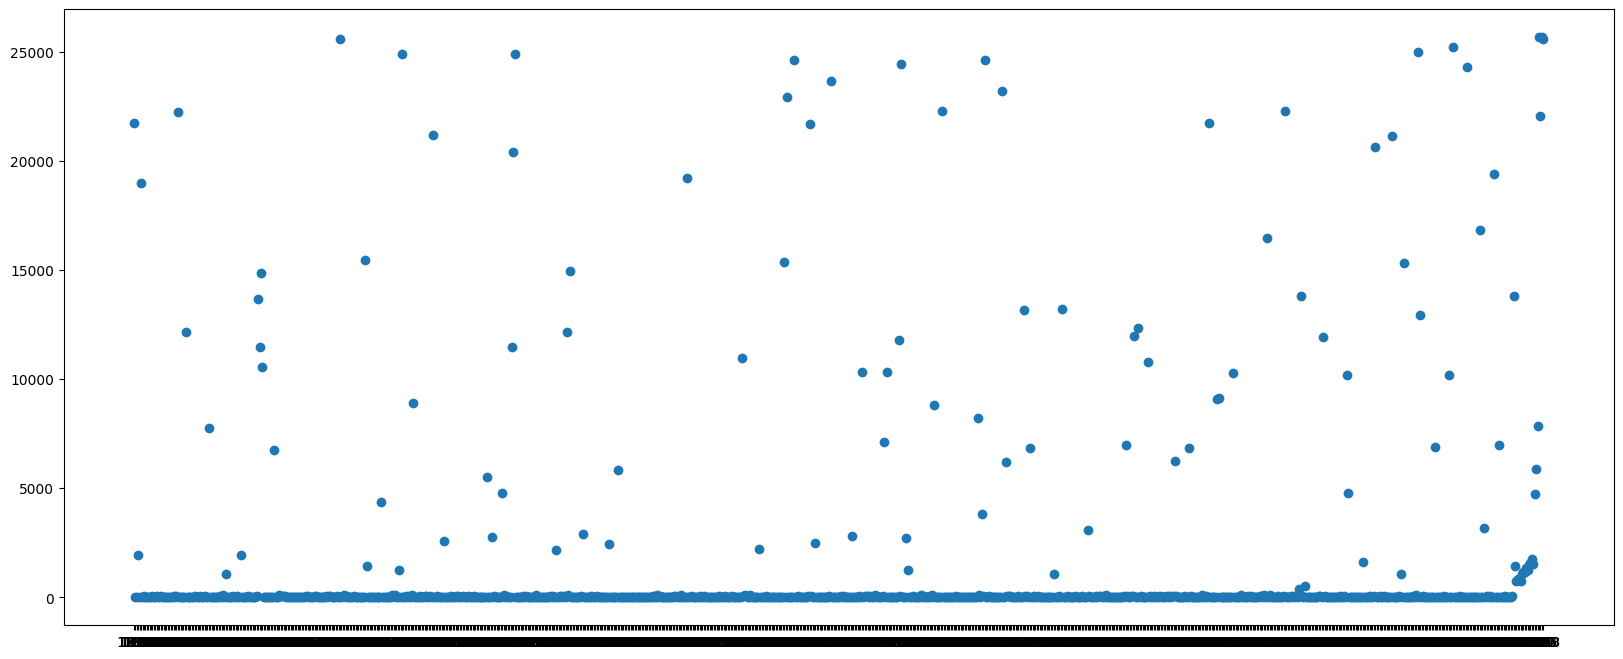

In [20]:
plt.figure(figsize=(20, 8))
plt.scatter(concat_data.columns[:1000], concat_data.isna().sum()[:1000])